<a href="https://colab.research.google.com/github/sgr1118/Kaggle-Transcription/blob/main/%5Bfilb02%5DNatural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 캐글 API 불러오기
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rlfkr1234","key":"cf174d7e08b9e8738f8815cd6a5ad980"}'}

In [2]:
!ls -1ha kaggle.json
# kaggle json 파일 업로드 확인

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 140MB/s]


In [5]:
# 불러온 파일이 알집인 경우 
!unzip /content/nlp-getting-started.zip

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# 데이터셋 소개

1. 대회 이름 : Natural Language Processing with Disaster Tweets (재난 트위터 데이터셋을 사용한 자연어 처리)

2. 분석 목표 : 실제 재난 트윗과 그렇지 않은 트윗을 예측하는 머신러닝 모델 만들기

3. 데이터셋 이름 : train, test, sample_submission



# Table of Contents

1. Importing the necessary libraries

2. Reading the datasets

3. Basic EDA

4. Text data processing

5. Transforming tokens to vectors

6. Buiding a Text Classification model



# 1. Importing the necessary libraries (필수 라이브러리 불러오기)

In [5]:
import numpy as np
import pandas as pd

# text preprocessing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# pd.set_option
pd.set_option('display.max_rows', 100)

# 2. Reading the datasets

In [6]:
# train 데이터 불러오기

train = pd.read_csv('/content/train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


id : 각 트윗에 대한 고유 id

keyword : 트윗 문장속에 특정한 키워드 (아마 공란일 것이다)

location : 트윗을 작성한 장소 (아마 공란일 것이다)

text : 트윗 본문

target : 실제 재난인지 아닌지 구분, 실제 재난은 1, 아니면 0

In [7]:
# 테스트데이터 불러오기

test = pd.read_csv('/content/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 3. Basic EDA

Missing values (결측치 확인)

In [9]:
# train데이터에서 결측치 확인
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
# test데이터에서 결측치 확인
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

location에서 대량의 결측치가 있음을 확인하였다.

Exploring the Target Column (타겟 컬럼 확인하기)

- Distribution of the Target Column (타켓 컬럼의 분포)

In [ ]:
train['target'].value_counts()
# 일반 트위터 4342, 실제 재난 트위터 3271

0    4342
1    3271
Name: target, dtype: int64

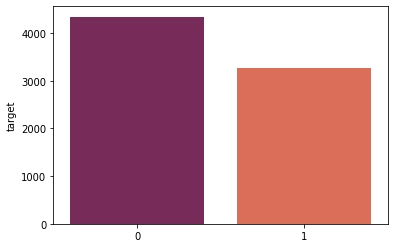

In [ ]:
# 타겟 컬럼 시각화
sns.barplot(train['target'].value_counts().index,
            train['target'].value_counts(), palette='rocket')

In [8]:
# 실제 재난 트위터 
disaster_tweets = train[train['target'] == 1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [9]:
# 일반 트위터
non_disaster_tweets = train[train['target'] == 0]['text']
non_disaster_tweets.values[1]

'I love fruits'

# Exploring the 'keyword' column (키워드 컬럼 확인)

키워드 컬럼 상위 20개 시각화

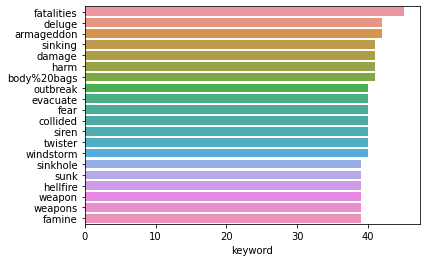

In [ ]:
# 키워드 시각화
sns.barplot(y = train['keyword'].value_counts()[:20].index,
            x = train['keyword'].value_counts()[:20], orient = 'h')

'disaster'라는 키워드가 트위터 문장에서 실제 재난인지 아닌지 결정하는데 도움이 되는지 확인

[str.contains 설명 보충]()

In [ ]:
# 트위터 문장 속 'disaster'확인

train.loc[train['text'].str.contains('disaster', na = False, case = False)].target.value_counts()

# 실제 재난 트위터에서 'disaster'는 102개, 일반 트위터에서는 40개
# na = False : NaN이 존재하는 경우 False로 치환
# case = False : 대문자 소문자를 구별하지 않는다.

1    102
0     40
Name: target, dtype: int64

Exploring the 'location' column (로케이션 컬럼 확인)

In [ ]:
# location 컬럼의 unique 확인
# location 컬럼에서 중복을 제외한 출력 값을 확인하고 전처리가 필요한 지 확인
import sys
np.set_printoptions(threshold=sys.maxsize)
pd.unique(train['location'])

# 내용이 상당히 복잡하게 출력되었다.
# 여기서 국가 별 집계를 편하기위한 전처리가 필요할 것으로 예상된다

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa', 'Sao Paulo, Brazil',
       'hollywoodland ', 'Edmonton, Alberta - Treaty 6',
       'Inang Pamantasan', 'Twitter Lockout in progress', 'Concord, CA',
       'Calgary, AB', 'San Francisco', 'CLVLND', 'Nashville, TN',
       'Santa Clara, CA', 'UK', 'St. Louis, MO', 'Walker County, Alabama',
       'Australia', 'North Carolina', 'Norf Carolina',
       'San Mateo County, CA', 'Njoro, Kenya', "Your Sister's Bedroom",
       'Arlington, TX', 'South Bloomfield, OH', 'New Hanover County, NC',
       'Maldives', 'Manchester, NH', 'Wilmington, NC', 'global',
       'Alberta | Sask. | Montana', 'Charlotte', 'Baton Rouge, LA',
       'Hagerstown, MD', '

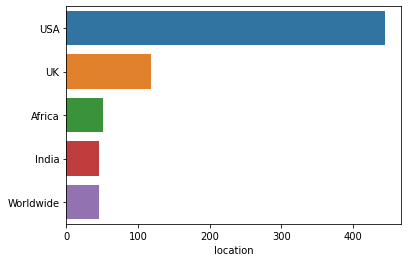

In [10]:
# loaction 전처리

train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

# 4. Text Data Preprocessing



1. Data Cleaning

NLP 프로젝트에서 데이터를 일관되게 갖고오기 위하여 전처리 과정은 반드시 필요하다

우리는 정제, 토크나이즈, 매트릭스에 넣을수 있게 변환해야합니다.

기초적인 문장의 전처리는 다음과 같은 과정이 포함됩니다.

(1) 대소문자 처리

(2) 노이즈 제거
- 구두점, 결측치, 무의미한 text

(3) 토큰화
- 토큰화 방법에 따라 문장을 찾을 수 있고, 단어를 찾을 수 있게 할 수 있다.

(4) 불용어 제거

토큰화 이후 추가 데이터 정리 단계 
[위키독스 어간 및 표제어 추출 설명](https://wikidocs.net/21707)

(1) 어간 추출 (Stemming)

(2) 표제어 추출 (Lemmatization)

[Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial/#.YzBxG3ZByzV)

![](https://kavita-ganesan.com/wp-content/uploads/2019/02/Screen-Shot-2019-02-23-at-1.36.52-PM-590x270.png)
<center></center>


In [ ]:
# text 데이터 확인

train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [ ]:
train['text'].sample(10)

4649    @allyinwondrland That sounds like the perfect ...
501     @envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...
5653    Rescue of the day: ItÛªs World Cat Day Saturd...
3501    New Explosion-proof Tempered Glass Screen Prot...
2419    On the eve of Jon Stewart leaving The Daily Sh...
5158    #LOL Plymouth (Û÷LetÛªs Obliterate LitterÛª...
4488    @Nervana_1 \nAs per previous behaviour JAN/AQ ...
2955    Given the US coalition's fondness for backing ...
7488    act my age was a MESS everyone was so wild it ...
2627    How American war planners singled out Hiroshim...
Name: text, dtype: object

[위키독스 정규표현식 참고](https://wikidocs.net/21703)

In [11]:
# 데이터 전처리 함수 구현
# re.sub : 문자열에서 정규 표현식과 일치하는 부분에 대해서 다른 문자열로 대체합니다. (replace로도 가능합니다.)
# re.escape : 문자열을 입력받으면 특수문자들을 이스케

def clean_text(text):
  text = text.lower() # 소문자화
  text = re.sub('\[.*?\]', '', text) # 대괄호 안에 text 제거
  text = re.sub('https?://\S+|www\.\S+', '', text) # 링크 제거
  text = re.sub('<.*?>+', '', text) # 
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text) # 줄 바꿈 제거
  text = re.sub('\w*\d\w*', '', text) # 숫자를 포함하는 문장 제거
  return text

In [12]:
# train, test에서 전처리 함수 적용

train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Text(0.5, 1.0, 'Non Disaster Tweets')

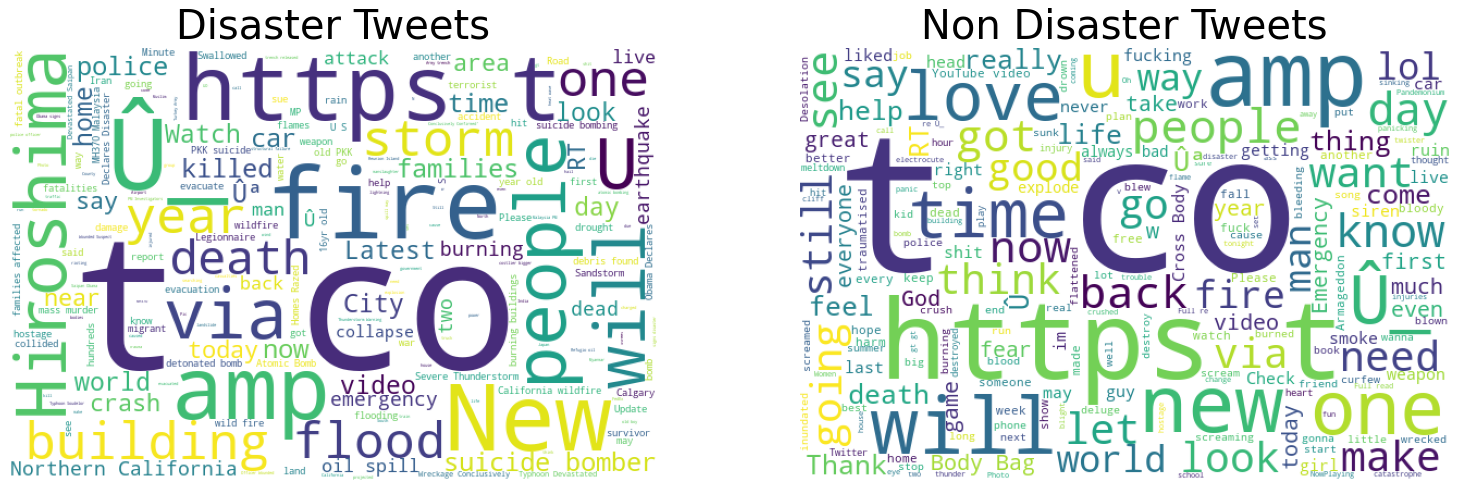

In [ ]:
# 재난 트윗과 일반 트윗의 워드 클라우드 제작

from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40)

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40)

2. Tokenization

토큰화는 단어, 문장, 문단 단위로 가능하다.

아래 예시를 통하여 확인해보자

[토큰화 위키독스](https://wikidocs.net/21698)

In [ ]:
# TreebankWordTokenizer : (1) 하이푼으로 구성된 단어는 하나로 유지한다. (2) doesn't와 같이 아포스트로피로 '접어'가 함께하는 단어는 분리해준다.

text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer() # 띄어쓰기 단위 토크나이저
tokenizer2 = nltk.tokenize.TreebankWordTokenizer() # 표준 토큰화
tokenizer3 = nltk.tokenize.WordPunctTokenizer() # 구두점을 별도로 구분하는 토크나이저
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print('Example Text:', text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text: Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [13]:
# train, text에 토크나이즈 적용

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # 정규표현식 토크나이저 사용 : 띄어쓰기 단위로 토큰화
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

3. Stopwords Removal (불용어 제거)

- a, an 등 관사를 제거할 것이다.

In [14]:
# 불용어 제거 함수 구현
nltk.download('stopwords')

def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


4. Token normalization (토큰 표준화)

토큰 정규화는 다른 토큰을 기본 형식으로 변환하는 것을 의미합니다.

- Stemming(어간 추출)

- Lemmatization (표제어 추출)

In [20]:
# 예시

nltk.download('wordnet')
nltk.download('omw-1.4')

text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# 어간 추출
stemmer = nltk.stem.PorterStemmer()
print('Stemming the sentence: ', ' '.join(stemmer.stem(token) for token in tokens))

# 표제어 추출
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


In [15]:
# 전처리 후 text 데이터 결합시키기
def combine_text(list_of_text):
  combined_text = ' '.join(list_of_text)
  return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
# 지금까지 전처리 과정을 한번에 진행하는 함수 구현

def text_preprocessing(text):
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
  nopunc = clean_text(text)
  tokenized_text = tokenizer.tokenize(nopunc)
  remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
  combined_text = ' '.join(remove_stopwords)
  return combined_text

# 5. Transforming tokens to a vector

문장을 전처리한 뒤 텍스트를 토큰화 시켜야합니다.

Bag of Words - Countvectorizer Features

In [16]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.fit_transform(test['text'])

# 0이 아닌 요소를 유지시켜준다.
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


TFIDF Features

Term Frequency: is a scoring of the frequency of the word in the current document.

In [17]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

# 6. Building a Text Classification model
(Text 분류 모델 만들기)

[sklearn cross_val_score가이드](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score)

sklearn.model_selection.cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)

- estimator : 분류 / 회귀 구분 인자
- X : feature 데이터 셋
- y : label 데이터 셋
- scoring : 예측 성능 평가 지표
- cv : 교차 검증 폴드 수


사용하는 평가 지표 (F1-score)

![](https://velog.velcdn.com/images%2Fjadon%2Fpost%2Ff06f1d40-605d-4f13-b6ce-35c220c82968%2Fimage.png)
<center>f1-score 공식</center>

- 재현율과 정밀도의 조화평균으로 나타나며, 두 지표 중 어느 한쪽으로 치우지지 않을 때 상대적으로 높은 값을 가지게됩니다.
- accuracy가 아닌 f1-score를 사용하는 이유는 이진 분류에서 정확도는 성능을 왜곡할 수 있기 때문입니다.
- 예를 들어 100개의 데이터가 있고 이 중에서 90개의 데이터 레이블이 0, 10개의 데이터 레이블이 10이라고한다면 무조건 0으로 예측 결과를 반환하는 ML모델의 경우라도 정확도가 90%됩니다.

![](https://velog.velcdn.com/images%2Fjadon%2Fpost%2F355f2678-6504-48ec-aaaa-2dac7848d9a5%2Fimage.png)
<center>precision 공식</center>

- 정밀도는 예측을 pos로 한 대상 중에 예측과 실제 값이 pos로 일치하는 데이터의 비율을 뜻한다.
- pos 예측 성능을 더욱 정밀하게 측정하기위한 평가지표로 양성 예측도라고도 불린다.

![](https://velog.velcdn.com/images%2Fjadon%2Fpost%2Fae2e6ed1-5c05-4033-9cda-b6c0c42e0fe5%2Fimage.png)
<center>recall 공식</center>

- 재현율은 실제 값이 pos인 대상 중에 예측과 실제 값이 pos로 일치한 데이터의 비율을 뜻합니다.










Logistic Regression Classifier

In [25]:
# 로지스틱 회귀 모델 만들기

clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train['target'],
                                          cv=5, scoring='f1')
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [26]:
clf.fit(train_vectors, train['target'])

LogisticRegression()

In [24]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

Naives Bayes Classifier

In [26]:
clf_NB = MultinomialNB()

scores = model_selection.cross_val_score(clf_NB, train_vectors, train['target'], cv = 5, scoring = 'f1')
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [27]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB()

In [28]:
# TF-IDF에 나이브 베이즈 적용

clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring='f1')
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [30]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB()

XGBoost

In [20]:
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                              subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train['target'], cv=5, scoring='f1')
scores

array([0.47379913, 0.37379576, 0.43988816, 0.38900634, 0.53142857])

In [21]:
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.48947951, 0.34406439, 0.43140965, 0.40084388, 0.53014354])

# 

1. LogisticRegression
- array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

2. naive Bayes
- array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

3. Xgboost
- array([0.47379913, 0.37379576, 0.43988816, 0.38900634, 0.53142857])

전체적으로 naive Bayes가 CounterVetorize를 사용할 때 더 좋은 성능을 보여준다.



1. LogisticRegression
- array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

2. naive Bayes
- array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

3. Xgboost
- array([0.48947951, 0.34406439, 0.43140965, 0.40084388, 0.53014354])

전체적으로 naive Bayes가 TF-IDF를 사용할 때 더 좋은 성능을 보여준다.



제출용 파일 만들기

In [22]:
def submission(submission_file_path, model, test_vectors):
  sample_submission = pd.read_csv(submission_file_path)
  sample_submission["target"] = model.predict(test_vectors)
  sample_submission.to_csv("submission.csv", index=False)

In [31]:
submission_file_path = "/content/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)

# 추가적으로 할 수 있는 작업

1. GridSearchCV로 최적 하이퍼 파라미터 찾기

사용할 ML model: XGBoost

1. GridSearchCV로 최적 하이퍼 파라미터 찾기

In [42]:
# 하이퍼 파라미터 범위 적용
param_grid = {'max_depth': [5, 20],
    'learning_rate' : [0.01, 0.05, 0.1],
    'num_iterations' : [1000, 2000],
    'colsample_bytree' : [0.5, 1],
    'subsample' : [0.5, 1],
    'nthread' : [10, 20]}

In [43]:
# 학습 모델 선정
model_1 = XGBClassifier(random_state=10)

In [44]:
# 그리스 서치 모델
grid_model = GridSearchCV(model_1, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=5)
grid_model.fit(train_tfidf, train["target"])

# 걸린 시간 : 20분 24초

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=XGBClassifier(random_state=10), n_jobs=5,
             param_grid={'colsample_bytree': [0.5, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 20], 'nthread': [10, 20],
                         'num_iterations': [1000, 2000],
                         'subsample': [0.5, 1]},
             scoring='f1', verbose=1)

In [45]:
grid_model.cv_results_

{'mean_fit_time': array([ 4.4893961 ,  3.54560471,  3.60061426,  3.82415752,  4.36315742,
         4.63536916,  4.82547202,  4.47543435, 13.35882611, 13.56801095,
        12.36951656, 13.84932032, 16.0578546 , 17.55741401, 16.65341702,
        17.91084642,  3.62858081,  3.69374776,  3.54496484,  3.79146519,
         4.29304218,  4.72675328,  4.48321962,  4.53780818, 13.0963057 ,
        13.34824777, 12.76095276, 13.81014824, 16.10734358, 17.5246191 ,
        16.43523955, 17.19673505,  3.92184772,  3.63883438,  3.68149195,
         3.91465831,  4.32130389,  4.65541587,  4.49181356,  4.54063816,
        12.65547442, 13.35630584, 12.2944922 , 13.68653927, 15.6697979 ,
        16.8194438 , 16.35588598, 17.17170835,  5.98512454,  6.17986469,
         6.13489914,  6.38790545,  6.39458289,  6.66809111,  7.06763821,
         6.77243562, 23.11237783, 25.10413327, 22.85667534, 25.40791707,
        24.99743514, 28.40695953, 25.23179255, 28.01351504,  6.12919259,
         6.28920245,  5.90793757, 

In [46]:
params = grid_model.cv_results_['params']
params

[{'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'nthread': 10,
  'num_iterations': 1000,
  'subsample': 0.5},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'nthread': 10,
  'num_iterations': 1000,
  'subsample': 1},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'nthread': 10,
  'num_iterations': 2000,
  'subsample': 0.5},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'nthread': 10,
  'num_iterations': 2000,
  'subsample': 1},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'nthread': 20,
  'num_iterations': 1000,
  'subsample': 0.5},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'nthread': 20,
  'num_iterations': 1000,
  'subsample': 1},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'nthread': 20,
  'num_iterations': 2000,
  'subsample': 0.5},
 {'colsample_bytree': 0.5,
  'learning_rate': 0.01,
  'max_depth': 5

In [47]:
score = grid_model.cv_results_['mean_test_score']
score

array([0.26235471, 0.26823001, 0.26235471, 0.26823001, 0.26235471,
       0.26823001, 0.26235471, 0.26823001, 0.36501484, 0.38078941,
       0.36501484, 0.38078941, 0.36501484, 0.38078941, 0.36501484,
       0.38078941, 0.36722579, 0.3638213 , 0.36722579, 0.3638213 ,
       0.36722579, 0.3638213 , 0.36722579, 0.3638213 , 0.42340584,
       0.41086123, 0.42340584, 0.41086123, 0.42340584, 0.41086123,
       0.42340584, 0.41086123, 0.40509999, 0.38751973, 0.40509999,
       0.38751973, 0.40509999, 0.38751973, 0.40509999, 0.38751973,
       0.46297722, 0.45113956, 0.46297722, 0.45113956, 0.46297722,
       0.45113956, 0.46297722, 0.45113956, 0.2722744 , 0.26414353,
       0.2722744 , 0.26414353, 0.2722744 , 0.26414353, 0.2722744 ,
       0.26414353, 0.3700218 , 0.36694607, 0.3700218 , 0.36694607,
       0.3700218 , 0.36694607, 0.3700218 , 0.36694607, 0.38448031,
       0.36560859, 0.38448031, 0.36560859, 0.38448031, 0.36560859,
       0.38448031, 0.36560859, 0.42880612, 0.40837085, 0.42880

In [48]:
results = pd.DataFrame(params)
results['score'] = score
results

# learning_rate	max_depth	num_iterations	

,colsample_bytree,learning_rate,max_depth,nthread,num_iterations,subsample,score
0,0.5,0.01,5,10,1000,0.5,0.262355
1,0.5,0.01,5,10,1000,1.0,0.268230
2,0.5,0.01,5,10,2000,0.5,0.262355
3,0.5,0.01,5,10,2000,1.0,0.268230
4,0.5,0.01,5,20,1000,0.5,0.262355
5,0.5,0.01,5,20,1000,1.0,0.268230
6,0.5,0.01,5,20,2000,0.5,0.262355
7,0.5,0.01,5,20,2000,1.0,0.268230
8,0.5,0.01,20,10,1000,0.5,0.365015
9,0.5,0.01,20,10,1000,1.0,0.380789


In [49]:
results = results['score'].sort_values(ascending=False)
results

# 가장 높은 score : 0.462977

40    0.462977
46    0.462977
44    0.462977
42    0.462977
94    0.461343
88    0.461343
92    0.461343
90    0.461343
41    0.451140
47    0.451140
45    0.451140
43    0.451140
95    0.444008
89    0.444008
93    0.444008
91    0.444008
78    0.428806
74    0.428806
72    0.428806
76    0.428806
24    0.423406
30    0.423406
28    0.423406
26    0.423406
27    0.410861
31    0.410861
29    0.410861
25    0.410861
80    0.409930
84    0.409930
82    0.409930
86    0.409930
73    0.408371
75    0.408371
77    0.408371
79    0.408371
36    0.405100
38    0.405100
32    0.405100
34    0.405100
37    0.387520
39    0.387520
35    0.387520
33    0.387520
85    0.386415
87    0.386415
81    0.386415
83    0.386415
64    0.384480
68    0.384480
70    0.384480
66    0.384480
15    0.380789
13    0.380789
9     0.380789
11    0.380789
58    0.370022
56    0.370022
60    0.370022
62    0.370022
16    0.367226
18    0.367226
20    0.367226
22    0.367226
63    0.366946
61    0.366946
59    0.36

In [50]:
# 가장 스코어가 높았던 조합으로 학습 시행
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=20, n_estimators=1000, colsample_bytree=0.5, 
                        subsample=0.5, nthread=20, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.52866242, 0.43208751, 0.47627574, 0.44995045, 0.59581882])

In [53]:
clf_xgb_TFIDF.fit(train_tfidf, train["target"])

XGBClassifier(colsample_bytree=0.5, max_depth=20, n_estimators=1000, nthread=20,
              subsample=0.5)

In [54]:
submission_file_path = "/content/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_xgb_TFIDF,test_vectors)

# Kaggle Score 집계

1. 기존 NB 모델
- Score: 0.79711, ranking : 348

2. GridSearchCV 사용 Xgboost모델
- Score: 0.77260